<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-&amp;-Declarations" data-toc-modified-id="Imports-&amp;-Declarations-1">Imports &amp; Declarations</a></span><ul class="toc-item"><li><span><a href="#Define-the-geographic-area-of-interest" data-toc-modified-id="Define-the-geographic-area-of-interest-1.1">Define the geographic area of interest</a></span></li></ul></li><li><span><a href="#Data-acquisition,-cleaning,-&amp;-exploration" data-toc-modified-id="Data-acquisition,-cleaning,-&amp;-exploration-2">Data acquisition, cleaning, &amp; exploration</a></span><ul class="toc-item"><li><span><a href="#Foursquare-Venues" data-toc-modified-id="Foursquare-Venues-2.1">Foursquare Venues</a></span></li><li><span><a href="#Venue-categories,-groups,-&amp;-types" data-toc-modified-id="Venue-categories,-groups,-&amp;-types-2.2">Venue categories, groups, &amp; types</a></span></li><li><span><a href="#Vizualizing-venues" data-toc-modified-id="Vizualizing-venues-2.3">Vizualizing venues</a></span></li></ul></li><li><span><a href="#Modeling-&amp;-evaluation" data-toc-modified-id="Modeling-&amp;-evaluation-3">Modeling &amp; evaluation</a></span></li></ul></div>

# Getting to know Rexburg, Idaho, USA
**Where to live, where to eat, what to do**

_Coursera Applied Data Science Capstone Project, January 2020_

## Imports & Declarations

In [1]:
import math
import numpy as np
import pandas as pd
import requests

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium
from folium.features import DivIcon

import capstone_functions as cf

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

### Define the geographic area of interest

Rexburg's four corners:
- NW: 43.840199, -111.807453
- NE: 43.840199, -111.757579
- SW: 43.804226, -111.807453
- SE: 43.804226, -111.757579

4km square

In [2]:
grid_size = 15

In [7]:
cf.draw_rexburg_map(grid_size, grid_numbers=True)

## Data acquisition, cleaning, & exploration

### Foursquare Venues

In [4]:
rexburg_venues = cf.get_nearby_venues(range(1, grid_size**2 + 1), 
                                      grid_segment_centers[:, 0], 
                                      grid_segment_centers[:, 1], 
                                      radius=grid_radius)
print(f'\n{rexburg_venues.shape[0]} venues retrieved.')

Getting grid sections: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 
21741 venues retrieved.


In [6]:
rexburg_venues.drop_duplicates(['venue', 'v_lat', 'v_long'], inplace=True)
print(f'{rexburg_venues.shape[0]} remain after dropping duplicates.')

898 remain after dropping duplicates.


In [7]:
for row in rexburg_venues.itertuples():
    rexburg_venues.loc[row.Index, 
                       'grid_section'] = cf.venue_grid_section(row.v_lat, 
                                                               row.v_long, 
                                                               grid_squares)

In [8]:
rexburg_venues.grid_section.isnull().sum()

105

In [9]:
rexburg_venues.dropna(inplace=True)
rexburg_venues.isnull().sum().sum()

0

In [11]:
map_venues = folium.Map(location=map_center, zoom_start=13)

folium.Polygon(
    [each for each in CORNERS], color='gray', weight=2
    ).add_to(map_venues)

for lat, long, label in zip(rexburg_venues.v_lat, 
                            rexburg_venues.v_long, 
                            rexburg_venues.venue):
    folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        fill=True,
        color='black',
        fill_color='black',
        fill_opacity=0.25,
        weight=1
        ).add_to(map_venues)

counter = 1
for square, center in zip(grid_squares.reshape(-1, 2, 2), 
                          grid_segment_centers):
    folium.Rectangle(
        square,
        color='gray',
        fill=False,
        weight=0.5,
        ).add_to(map_venues)

    counter += 1
    
map_venues

In [12]:
rexburg_venues.head()

grid_section  grid_section_lat  grid_section_long  \
1          49.0            43.839        -111.805791   
2          63.0            43.839        -111.805791   
3          32.0            43.839        -111.805791   
5          18.0            43.839        -111.805791   
6          96.0            43.839        -111.805791   

                                             venue      v_lat      v_long  \
1                              Madison County Fair  43.830932 -111.796751   
2  The Church of Jesus Christ of Latter-day Saints  43.829912 -111.800706   
3                                      Nature Park  43.834798 -111.801264   
5                                       Eagle park  43.837360 -111.798076   
6                                    Great Scott's  43.825128 -111.788920   

      category  
1  Flea Market  
2       Church  
3         Park  
5         Park  
6  Gas Station

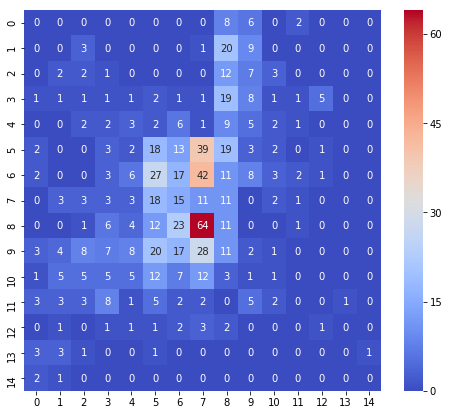

In [26]:
section_venues = pd.DataFrame(index=range(1, grid_size**2 + 1)
                             ).join(rexburg_venues['grid_section'].value_counts())
section_venues.columns = ['venue_count']
plt.figure(figsize=(8,7))
sns.heatmap(section_venues.fillna(0).venue_count.values.reshape(15, 15),
            cmap='coolwarm', annot=True);

In [14]:
rexburg_venues.to_csv('data/rexburg_venues.csv', index=False)

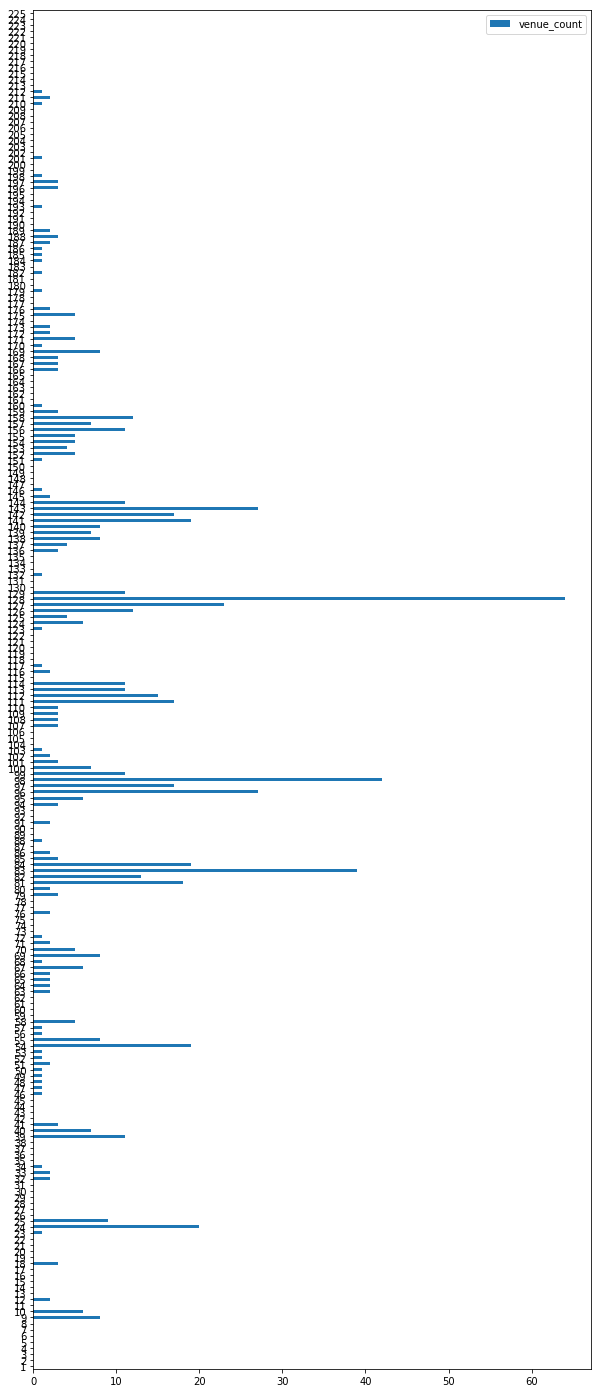

In [35]:
section_venues = pd.DataFrame(index=range(1, grid_size**2 + 1)
                             ).join(rexburg_venues['grid_section'].value_counts())
section_venues.columns = ['venue_count']
section_venues.plot.barh(figsize=(10,25));

In [12]:
len(rexburg_venues[rexburg_venues['category'].str.contains('None')
                  ].sort_values(by='venue').iloc[:, -4:])

30

In [13]:
# [Delete]
venues_to_delete = (
"""Alterra Pest Control
CALl
Dr. Gates
SSI
Spencer W. Kimball 292 Conference Room
The Dorms
The Hays'
The Lions Den
The Minariks
The Moseley's
Williams Engineering Buiding
wwe Universe
Upper Valley Vet
""".splitlines())

rexburg_venues.drop(
    rexburg_venues[(rexburg_venues['venue'].isin(venues_to_delete)) & 
                   (rexburg_venues['category'] == 'None')].index,
    inplace=True)

In [14]:
category_updates = {}

# Automotive Shop
category_updates = cf.add_category_change(
    'Automotive Shop',
    "0500 Mechanics|Tire Factory".split('|'), 
    category_updates)

# Church
category_updates = cf.add_category_change(
    'Church', 
    ['Stonebridge Ward Chapel'], 
    category_updates)

# College Administrative Building
category_updates = cf.add_category_change(
    'College Administrative Building',
    "BYU-Idaho Alumni Center|Ricks Hall".split('|'), 
    category_updates)

# High School
category_updates = cf.add_category_change(
    'High School',
    ['Madison High School'], 
    category_updates)

# Hotel
category_updates = cf.add_category_change(
    'Hotel',
    "Comfort Inn|Days Inn".split('|'), 
    category_updates)

# Lighting Store
category_updates = cf.add_category_change(
    'Lighting Store', 
    ['Wolfe Lighting & Accents'], 
    category_updates)

# Mexican Restaurant
category_updates = cf.add_category_change(
    'Mexican Restaurant',
    "Izcalli Mexican Food|Tacos Izcalii|Taqueria la Fondita".split('|'), 
    category_updates)

# Movie Theater
category_updates = cf.add_category_change(
    'Movie Theater', 
    ['paramount twin'], 
    category_updates)

# Park
category_updates = cf.add_category_change(
    'Park', 
    ['Slide Hill'], 
    category_updates)

# Post Office
category_updates = cf.add_category_change(
    'Post Office', 
    ['USPS office'], 
    category_updates)

# Real Estate Office
category_updates = cf.add_category_change(
    'Real Estate Office', 
    ['Century 21'], 
    category_updates)

# Residential Building (Apartment / Condo)
category_updates = cf.add_category_change(
    'Residential Building (Apartment / Condo)',
    "Aalita|Greenbrier|Twin Pines Manor|West Tisbury|Allen Ridge".split('|'), 
    category_updates)

# Tanning Salon
category_updates = cf.add_category_change(
    'Tanning Salon',
    ['Radiance Tanning & Salon'], 
    category_updates)

In [15]:
for new_category, venues_to_change in category_updates.items():
    rexburg_venues.loc[
        (rexburg_venues['venue'].isin(venues_to_change)) & 
        (rexburg_venues['category'] == 'None'),
        'category'] = new_category

In [16]:
rexburg_venues[rexburg_venues['category'].str.contains('None')
              ].sort_values(by='venue').iloc[:, -4:]

Empty DataFrame
Columns: [venue, v_lat, v_long, category]
Index: []

In [17]:
if len(rexburg_venues[rexburg_venues['category'].str.contains('None')]) != 0:
    raise ValueError(
            'Blank categories exist and must be resolved. See cell above.')

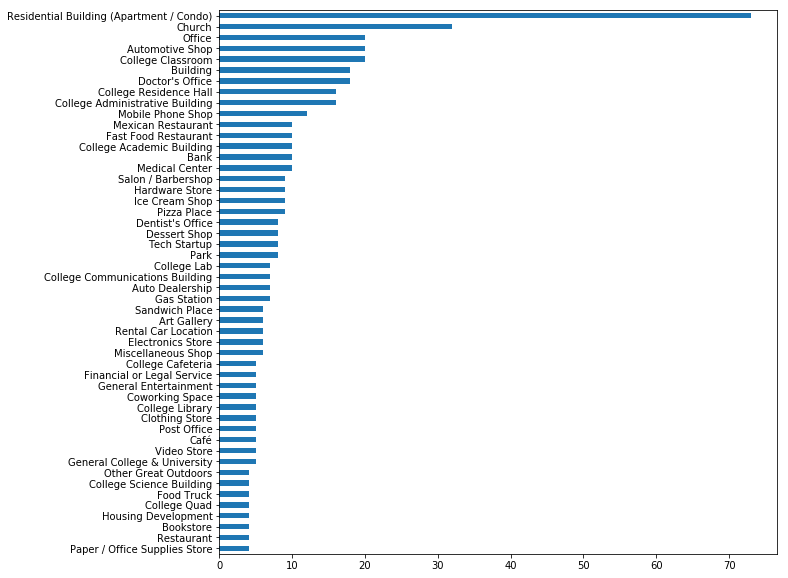

In [18]:
rexburg_venues['category'].value_counts().sort_values()[-50:].plot.barh(
    figsize=(10,10));

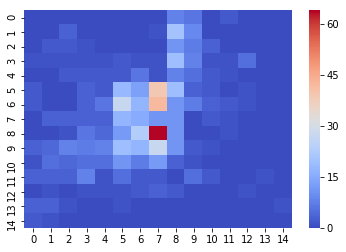

In [67]:
section_venues = pd.DataFrame(index=range(1, grid_size**2 + 1)
                             ).join(rexburg_venues['grid_section'].value_counts())
section_venues.columns = ['venue_count']
sns.heatmap(section_venues.fillna(0).venue_count.values.reshape(15, 15),
            cmap='coolwarm');

### Venue categories, groups, & types

In [19]:
cf.categories.shape

(941, 3)

In [20]:
rexburg_venues['group'] = rexburg_venues['category'].apply(
    lambda x: cf.map_category_group(x, 1))
rexburg_venues['type'] = rexburg_venues['category'].apply(
    lambda x: cf.map_category_group(x, 0))
rexburg_venues.head()

grid_section  grid_section_lat  grid_section_long  \
2            32            43.839        -111.805791   
3            63            43.839        -111.805791   
4            49            43.839        -111.805791   
5            18            43.839        -111.805791   
6            81            43.839        -111.805791   

                                             venue      v_lat      v_long  \
2                                      Nature Park  43.834798 -111.801264   
3  The Church of Jesus Christ of Latter-day Saints  43.829912 -111.800706   
4                              Madison County Fair  43.830932 -111.796751   
5                                       Eagle park  43.837360 -111.798076   
6                          Broulim's Grocery Store  43.826894 -111.787574   

        category              group                         type  
2           Park               Park        Outdoors & Recreation  
3         Church   Spiritual Center  Professional & Other Places  
4    Flea Market        Flea Market               Shop & Service  
5           Park               Park        Outdoors & Recreation  
6  Grocery Store  Food & Drink Shop               Shop & Service

In [21]:
rexburg_apartments = rexburg_venues[rexburg_venues['category'
                                                  ].str.contains('Resid')]
rexburg_food = rexburg_venues[rexburg_venues['type'
                                            ].str.contains('Food')]
rexburg_recreation = rexburg_venues[rexburg_venues['type'
                                                  ].str.contains('Outd')]

### Vizualizing venues

In [22]:
map_venues = folium.Map(location=map_center, zoom_start=13)

folium.Polygon(
    [each for each in CORNERS], color='gray', weight=2
    ).add_to(map_venues)

for lat, long, label in zip(rexburg_apartments.v_lat, 
                            rexburg_apartments.v_long, 
                            rexburg_apartments.venue):
    folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.5,
        weight=1
        ).add_to(map_venues)

for lat, long, label in zip(rexburg_food.v_lat, 
                            rexburg_food.v_long, 
                            rexburg_food.venue):
    folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        fill=True,
        color='red',
        fill_color='red',
        fill_opacity=0.5,
        weight=1
        ).add_to(map_venues)

for lat, long, label in zip(rexburg_recreation.v_lat, 
                            rexburg_recreation.v_long, 
                            rexburg_recreation.venue):
    folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        fill=True,
        color='green',
        fill_color='green',
        fill_opacity=0.5,
        weight=1
        ).add_to(map_venues)

counter = 1
for square, center in zip(grid_squares.reshape(-1, 2, 2), 
                          grid_segment_centers):
    folium.Rectangle(
        square,
        color='gray',
        fill=False,
        weight=0.5,
        ).add_to(map_venues)

    folium.map.Marker(
        center,
        icon=DivIcon(icon_size=(1,1),
                     icon_anchor=(5,5),
                     html=f'<div style="text-align:center;font-size:8pt;'
                          f'color:gray;font-weight:bold">{counter}</div>')
        ).add_to(map_venues)
    counter += 1
    
map_venues

## Modeling & evaluation

In [68]:
grid_categories = pd.crosstab(rexburg_venues.grid_section, rexburg_venues.group)
grid_categories = pd.DataFrame(index=range(1, grid_size**2 + 1)
                              ).join(grid_categories).fillna(0)
grid_categories.sample(10)

ATM  Airport  American Restaurant  Animal Shelter  Arcade  Art Gallery  \
106  0.0      0.0                  0.0             0.0     0.0          0.0   
192  0.0      0.0                  0.0             0.0     0.0          0.0   
160  0.0      0.0                  0.0             0.0     0.0          0.0   
120  0.0      0.0                  0.0             0.0     0.0          0.0   
157  0.0      0.0                  0.0             0.0     0.0          0.0   
115  0.0      0.0                  0.0             0.0     0.0          0.0   
96   0.0      0.0                  0.0             0.0     0.0          0.0   
131  0.0      0.0                  0.0             0.0     0.0          0.0   
166  0.0      0.0                  0.0             0.0     0.0          0.0   
162  0.0      0.0                  0.0             0.0     0.0          0.0   

     Arts & Crafts Store  Asian Restaurant  Assisted Living  \
106                  0.0               0.0              0.0   
192                  0.0               0.0              0.0   
160                  0.0               0.0              0.0   
120                  0.0               0.0              0.0   
157                  0.0               0.0              0.0   
115                  0.0               0.0              0.0   
96                   0.0               0.0              0.0   
131                  0.0               0.0              0.0   
166                  0.0               0.0              0.0   
162                  0.0               0.0              0.0   

     Athletics & Sports  ...  Strip Club  Student Center  Tanning Salon  \
106                 0.0  ...         0.0             0.0            0.0   
192                 0.0  ...         0.0             0.0            0.0   
160                 0.0  ...         0.0             0.0            0.0   
120                 0.0  ...         0.0             0.0            0.0   
157                 0.0  ...         0.0             0.0            0.0   
115                 0.0  ...         0.0             0.0            0.0   
96                  0.0  ...         0.0             0.0            0.0   
131                 0.0  ...         0.0             0.0            0.0   
166                 1.0  ...         0.0             0.0            0.0   
162                 0.0  ...         0.0             0.0            0.0   

     Tea Room  Thrift / Vintage Store  Trade School  Trail  University  \
106       0.0                     0.0           0.0    0.0         0.0   
192       0.0                     0.0           0.0    0.0         0.0   
160       0.0                     0.0           0.0    0.0         0.0   
120       0.0                     0.0           0.0    0.0         0.0   
157       0.0                     0.0           0.0    0.0         0.0   
115       0.0                     0.0           0.0    0.0         0.0   
96        0.0                     0.0           0.0    0.0         0.0   
131       0.0                     0.0           0.0    0.0         0.0   
166       0.0                     0.0           0.0    0.0         0.0   
162       0.0                     0.0           0.0    0.0         0.0   

     Video Game Store  Video Store  
106               0.0          0.0  
192               0.0          0.0  
160               0.0          0.0  
120               0.0          0.0  
157               0.0          0.0  
115               0.0          0.0  
96                0.0          1.0  
131               0.0          0.0  
166               0.0          0.0  
162               0.0          0.0  

[10 rows x 156 columns]

In [24]:
grid_categories_scaled = grid_categories / grid_categories.max().max()
grid_categories_scaled.shape

(225, 156)

In [36]:
results = []

for clusters in range(2, 121):
    km = KMeans(n_clusters=clusters, n_jobs=-1, random_state=1280)
    km.fit(grid_categories_scaled)
    result = km.get_params()
    result['labels_'] = km.labels_
    result['inertia'] = km.inertia_
    try:
        result['silhouette_score'] = silhouette_score(grid_categories_scaled, 
                                                      km.labels_)
    except ValueError:
        result['silhouette_score'] = None
    results.append(result)

/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (110) found smaller than n_clusters (111). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (110) found smaller than n_clusters (112). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (110) found smaller than n_clusters (113). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (110) found smaller than n_clusters (114). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of di

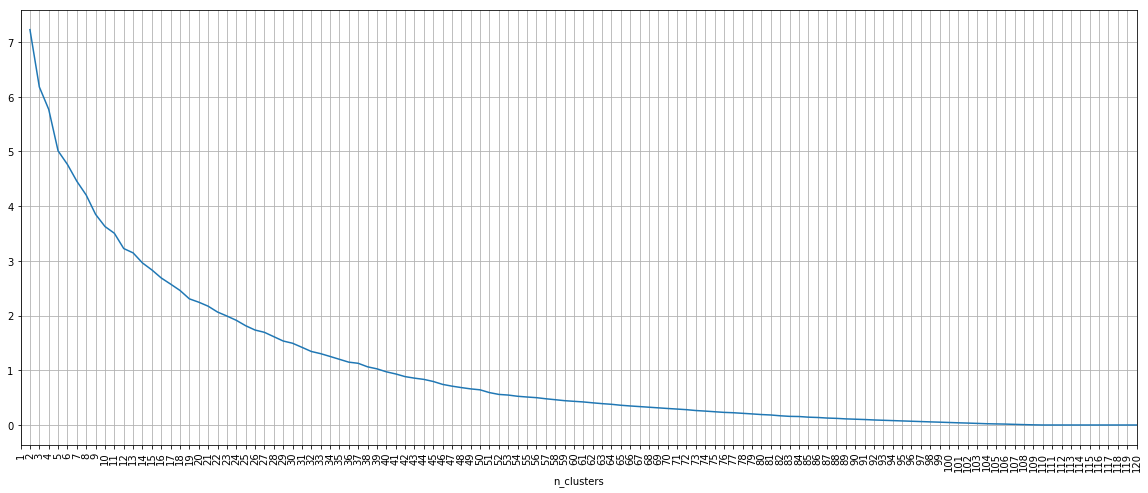

In [72]:
km_results = pd.DataFrame(results).set_index('n_clusters')
km_results['inertia'].plot(xticks=range(1, 121), 
                           figsize=(20,8), 
                           rot=90)
plt.grid(axis='both');

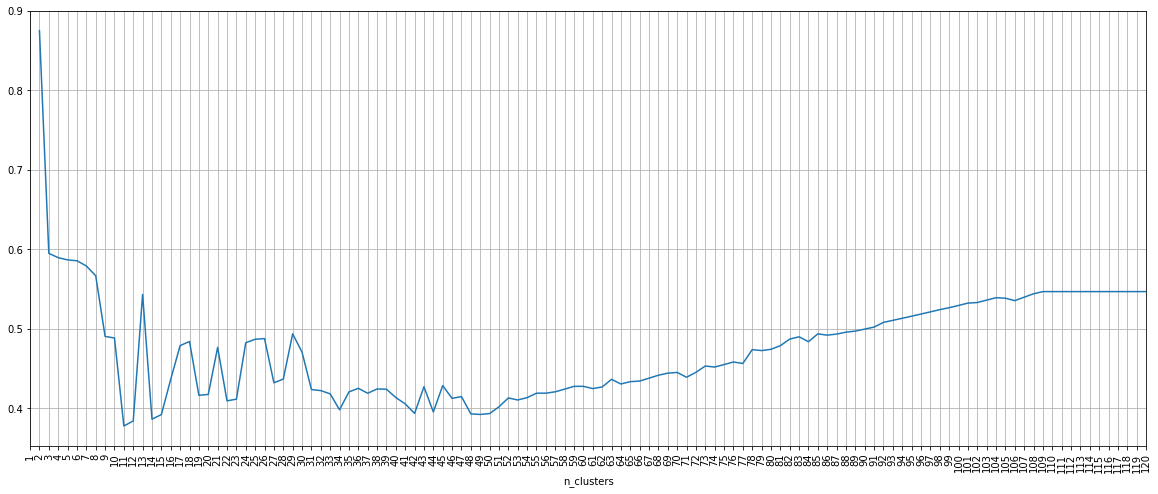

In [41]:
km_results['silhouette_score'].plot(xticks=range(1, 121), 
                                    figsize=(20,8),
                                    rot=90)
plt.grid(axis='both');

In [78]:
kclusters = 5
km_results.loc[kclusters, 'inertia':'silhouette_score']

inertia             5.00995
silhouette_score    0.58653
Name: 5, dtype: object

In [79]:
grid_categories['cluster'] = km_results.loc[kclusters].labels_ + 1
grid_categories['grid_section_lat'] = grid_segment_centers[:, 0]
grid_categories['grid_section_long'] = grid_segment_centers[:, 1]

In [80]:
grid_categories['cluster'].value_counts()

2    196
5     14
1     13
4      1
3      1
Name: cluster, dtype: int64

In [81]:
# create map
map_clusters = folium.Map(location=map_center, zoom_start=13)

folium.Polygon(
    [each for each in CORNERS], color='gray', weight=2
    ).add_to(map_clusters)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for (lat, lon, poi, 
    cluster, square, center) in zip(grid_categories['grid_section_lat'], 
                                   grid_categories['grid_section_long'], 
                                   grid_categories.index, 
                                   grid_categories['cluster'],
                                   grid_squares.reshape(-1, 2, 2),
                                   grid_segment_centers):
    
    label = folium.Popup(f'Grid {poi}' + ' Cluster ' + str(cluster + 1))

    folium.Rectangle(
        square,
        popup=label,
        color='gray',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.25,
        weight=0.5,
        ).add_to(map_clusters)

    folium.map.Marker(
        center,
        icon=DivIcon(icon_size=(0,0),
                     icon_anchor=(5,5),
                     html=f'<div style="text-align:center;font-size:8pt;'
                          f'color:#2C66AB;font-weight:bold">{cluster}</div>')
        ).add_to(map_clusters)
       
map_clusters

In [82]:
# create map
map_final = folium.Map(location=map_center, zoom_start=13)

folium.Polygon(
    [each for each in CORNERS], color='gray', weight=2
    ).add_to(map_final)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for (lat, lon, poi, 
    cluster, square, center) in zip(grid_categories['grid_section_lat'], 
                                   grid_categories['grid_section_long'], 
                                   grid_categories.index, 
                                   grid_categories['cluster'],
                                   grid_squares.reshape(-1, 2, 2),
                                   grid_segment_centers):
    
    label = folium.Popup(f'Grid {poi}' + ' Cluster ' + str(cluster + 1))

    folium.Rectangle(
        square,
        popup=label,
        color='gray',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.25,
        weight=0.5,
        ).add_to(map_final)

    folium.map.Marker(
        center,
        icon=DivIcon(icon_size=(0,0),
                     icon_anchor=(5,5),
                     html=f'<div style="text-align:center;font-size:8pt;'
                          f'color:#2C66AB;font-weight:bold">{cluster}</div>')
        ).add_to(map_final)

for lat, long, label in zip(rexburg_venues.v_lat, 
                            rexburg_venues.v_long, 
                            rexburg_venues.venue):
    folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        fill=True,
        color='gray',
        fill_color='gray',
        fill_opacity=0.25,
        weight=0.5
        ).add_to(map_final)
       
map_final

----